c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


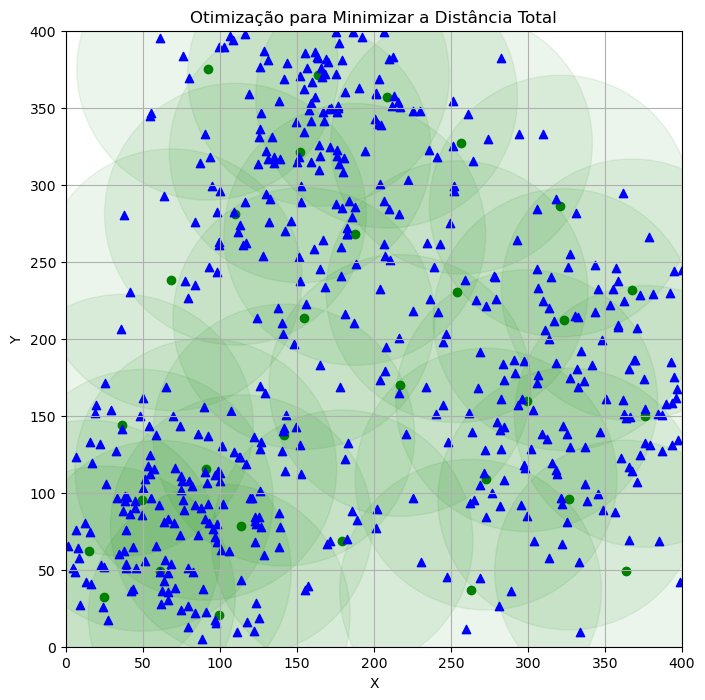

Minimização da Distância Total:
Número total de pontos de acesso: 18
Distância total: 24713.63822302558


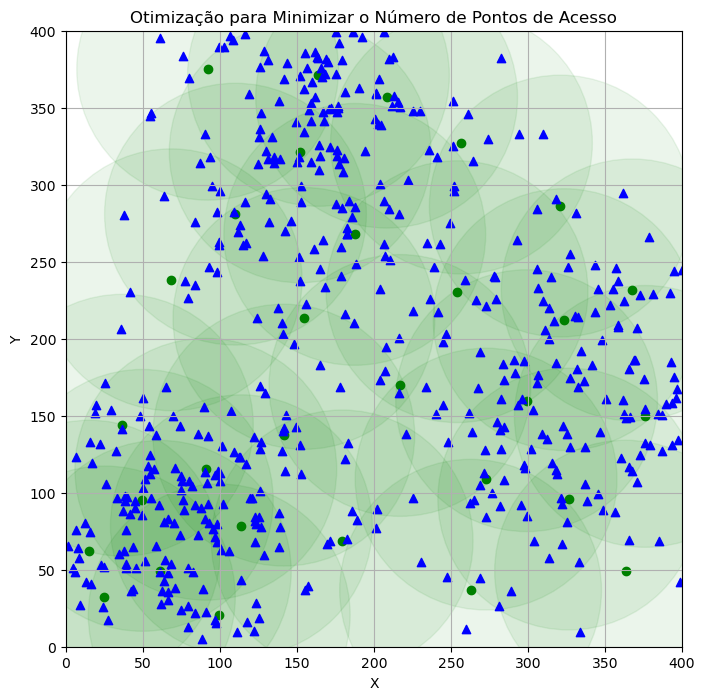

Minimização do Número Total de Pontos de Acesso:
Número total de pontos de acesso: 18
Distância total: 24713.63822302558


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import math
import copy
from matplotlib.patches import Circle

# Parâmetros do problema
num_clients = 495
max_access_points = 30
grid_size = 400  # Tamanho do centro de convenções
max_distance = 85  # Distância máxima entre cliente e ponto de acesso
used_distance = 80
access_point_capacity = 54  # Capacidade máxima de cada ponto de acesso em Mbps
lambda_exposure = 1  # Coeficiente de exposição (sinal nominal do PA)
gamma_decay = 2  # Fator de decaimento ao quadrado

# Função para ler dados do arquivo CSV e normalizar coordenadas
def read_and_normalize_data(csv_file):
    df = pd.read_csv(csv_file, header=None, sep=',', names=['client_x', 'client_y', 'client_demand'])
    client_coordinates = df[['client_x', 'client_y']].values
    client_coordinates = client_coordinates / df[['client_x', 'client_y']].max().max() * grid_size
    bandwidth_demands = df['client_demand'].values
    return client_coordinates, bandwidth_demands

client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')

class Client:
    def __init__(self, id, x, y, banda):
        self.id = id
        self.x = x
        self.y = y
        self.banda = banda
        self.pa = None

class PontoAcesso:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.capacidade = access_point_capacity
        self.usuarios_conectados = []

    def try_connect_user(self, client: Client) -> bool:
        if self.capacidade < client.banda or self.distance(client.x, client.y) > max_distance:
            return False

        self.capacidade -= client.banda
        self.usuarios_conectados.append(client)
        return True
        
    def is_active(self) -> bool:
        return len(self.usuarios_conectados) > 0
    
    def users_connected(self) -> int:
        return len(self.usuarios_conectados)

    def disconnect_user(self, client: Client) -> None:
        if client in self.usuarios_conectados:
            self.usuarios_conectados.remove(client)
            self.capacidade += client.banda
            client.pa = None
    
    def distance(self, x: float, y: float) -> float:
        return math.dist([x, y], [self.x, self.y])

    def __repr__(self):
        return f"PontoAcesso(x={self.x}, y={self.y}, capacidade={self.capacidade}, usuarios_conectados={self.usuarios_conectados})"

class Solution:
    def __init__(self, pas : dict, clients: list) -> None:
        self.pas = pas
        self.clients = clients

    def try_connect_user(self, id: str, client: Client) -> bool:
        if self.pas[id].try_connect_user(client):
            self.clients[client.id].pa = id
            return True
        return False
    
    def disconnect_user(self, id: str, client: Client) -> bool:
        if self.pas[id].disconnect_user(client):
            self.clients[client.id].pa = None
            return True
        return False
    
    def active_access_point(self) -> int:
        counter = 0
        for value in self.pas.values():
            if len(value.usuarios_conectados) > 0:
                counter += 1
        return counter
    
    def total_distance(self) -> float:
        total_distance = 0
        for value in self.pas.values():
            for client in value.usuarios_conectados:
                total_distance += math.dist([value.x, value.y], [client.x, client.y])
        return total_distance
    
    def add_access_point(self, pa: PontoAcesso) -> bool:
        if len(self.pas.keys()) >= max_access_points:
            return False
        self.pas[str(len(self.pas.keys()))] = pa
        return True

    def is_valid_solution(self) -> bool:
        connected_users = [
            user
            for user in self.clients
            if user.pa is not None
        ]
        return (len(connected_users) / num_clients) > 0.98

    def check_exposure(self) -> bool:
        for client in self.clients:
            total_exposure = sum(
                lambda_exposure / (self.pas[client.pa].distance(client.x, client.y) ** gamma_decay)
                for pa in self.pas.values() if pa.is_active() and pa.distance(client.x, client.y) <= max_distance
            )
            if total_exposure < 0.05 * lambda_exposure:
                return False
        return True

clients = [Client(client_id, coordinates[0], coordinates[1], band) for client_id, (coordinates, band) in enumerate(zip(client_coordinates, bandwidth_demands))]

# Inicialização com K-means
kmeans = KMeans(n_clusters=max_access_points).fit(client_coordinates)
pas_dict = {str(i): PontoAcesso(str(i), kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]) for i in range(max_access_points)}

solution = Solution(pas_dict, clients)

def initial_solution(solution) -> Solution:
    temp_solution = copy.deepcopy(solution)
    remaining_pas = max_access_points - len(temp_solution.pas.keys())
    for client in temp_solution.clients:
        for pa in temp_solution.pas.values():
            if client.pa is None and temp_solution.try_connect_user(pa.id, client):
                break
        if client.pa is None and remaining_pas > 0:
            pa_t = len(temp_solution.pas.keys())
            temp_solution.add_access_point(PontoAcesso(str(pa_t), client.x, client.y))
            temp_solution.try_connect_user(str(pa_t), client)
            remaining_pas -= 1
    return temp_solution

def explore_neighborhood_swap(solution: Solution):
    new_solution = copy.deepcopy(solution)
    i = random.randint(0, len(new_solution.pas.keys()) - 1)
    disconnected_users = []
    for user_connected in new_solution.pas[str(i)].usuarios_conectados:
        new_solution.disconnect_user(str(i), user_connected)
        disconnected_users.append(user_connected)
    for user in disconnected_users:
        for pas in new_solution.pas.values():
            if pas.is_active() and new_solution.try_connect_user(pas.id, user):
                disconnected_users.remove(user)
                break
    return new_solution

def explore_neighborhood_exchange(solution: Solution):
    temp_solution = copy.deepcopy(solution)
    users_connected = math.inf
    for pa in temp_solution.pas.values():
        if pa.is_active() and len(pa.usuarios_conectados) < users_connected:
            least_used_pa = pa.id
    disconnected_users = temp_solution.pas[least_used_pa].usuarios_conectados
    for user in disconnected_users:
        temp_solution.disconnect_user(least_used_pa, user)
    for user in disconnected_users:
        for pa in temp_solution.pas.values():
            if temp_solution.try_connect_user(pa.id, user):
                break
    return temp_solution

def explore_neighborhood_insert(solution: Solution):
    new_solution = copy.deepcopy(solution)
    unatendent_clients = [
        client
        for client in new_solution.clients
        if client.pa is None
    ]
    if len(unatendent_clients) > 0:
        selected_client = random.choice(unatendent_clients)
        selected_pa = random.choice(list(new_solution.pas.keys()))
        new_solution.pas[selected_pa].x = selected_client.x
        new_solution.pas[selected_pa].y = selected_client.y
    return new_solution

def shake(solution: Solution, k: int) -> Solution:
    shaken_solution = copy.deepcopy(solution)
    for _ in range(k):
        operation = random.choice([
            explore_neighborhood_swap,
            explore_neighborhood_exchange,
            explore_neighborhood_insert,
        ])
        shaken_solution = operation(shaken_solution)
    return shaken_solution

k_max = 5
max_iterations = 1000

def optimize_distance(current_solution):
    current_k = 1
    iteration = 0

    while iteration < max_iterations:
        new_solution = shake(current_solution, current_k)
        if new_solution.is_valid_solution() and new_solution.check_exposure():
            improvement_criteria = new_solution.total_distance() < current_solution.total_distance()
            if improvement_criteria:
                current_solution = new_solution
                current_k = 1
            else:
                current_k += 1
        if current_k > k_max:
            break
        iteration += 1
    return current_solution

def optimize_access_points(current_solution):
    current_k = 1
    iteration = 0

    while iteration < max_iterations:
        new_solution = shake(current_solution, current_k)
        if new_solution.is_valid_solution() and new_solution.check_exposure():
            improvement_criteria = new_solution.active_access_point() < current_solution.active_access_point() or (
                new_solution.active_access_point() == current_solution.active_access_point() and
                new_solution.total_distance() < current_solution.total_distance()
            )
            if improvement_criteria:
                current_solution = new_solution
                current_k = 1
            else:
                current_k += 1
        if current_k > k_max:
            break
        iteration += 1
    return current_solution

# Gerar solução inicial
initial_solution_obj = initial_solution(solution)

# Otimização para minimizar a distância total
solution_distance = optimize_distance(copy.deepcopy(initial_solution_obj))

plt.figure(figsize=(8, 8))
for chave, valor in solution_distance.pas.items():
    plt.scatter(valor.x, valor.y, label=chave, color='green')
    circle = Circle((valor.x, valor.y), radius=max_distance, color='green', fill=True, alpha=0.08)
    plt.gca().add_patch(circle)
for client in solution_distance.clients:
    cor = 'blue' if client.pa is not None else 'red'
    plt.scatter(client.x, client.y, color=cor, marker='^')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Otimização para Minimizar a Distância Total')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print('Minimização da Distância Total:')
print('Número total de pontos de acesso:', solution_distance.active_access_point())
print('Distância total:', solution_distance.total_distance())

# Otimização para minimizar o número total de pontos de acesso
solution_ap = optimize_access_points(copy.deepcopy(initial_solution_obj))

plt.figure(figsize=(8, 8))
for chave, valor in solution_ap.pas.items():
    plt.scatter(valor.x, valor.y, label=chave, color='green')
    circle = Circle((valor.x, valor.y), radius=max_distance, color='green', fill=True, alpha=0.08)
    plt.gca().add_patch(circle)
for client in solution_ap.clients:
    cor = 'blue' if client.pa is not None else 'red'
    plt.scatter(client.x, client.y, color=cor, marker='^')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Otimização para Minimizar o Número de Pontos de Acesso')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print('Minimização do Número Total de Pontos de Acesso:')
print('Número total de pontos de acesso:', solution_ap.active_access_point())
print('Distância total:', solution_ap.total_distance())
